# Analyzing Insulin Clinical Trial Data 
------
**Overview**    
An experiment for testing the efficacy and the dose response of a new innovative oral insulin drug called “Auralin” plus identify common short term side effects. We have 350 patient, split into two groups. One hundred seventy-five or half treated with the new oral insulin “Auralin”, and the other 175 being treated with the popular injectable insulin called “Novodra”. By comparing key metrics between these two drugs, we can determine if Auralin is effective. The metric used is HbA1c and this metric measures how well your blood sugar levels have been controlled. If Auralin, the new oral insulin, can reduce HbA1c levels at a similar standard as the injectable insulin Novodra from some standard pretrial baseline, like say they both decrease HbA1c levels from 7.9% to 7.4%, that's a 0.5% drop. If we can get a 0.4 change, we've got ourselves a major medical breakthrough.
- -------
**Problem**    
   To release a new drug, there are essential stages it should pass through and limits not to break. Pre-defined metrics are used to achieve that.
-   ----------
**Dataset**    
Oral Insulin Phase II Clinical Trial Data   
-   ------
**Objective** analyze and visualize the clinical trial data to check effectiveness and safty

## Contents 
* [Gather](#Gather)
* [Analysis](#Analysis)
    * [Adverse Reactions](#Adverse_Reactions)
    * [Pre-trial/Post-trial Mean Insulin Dose Change (IU)](#Pre-trial/Post-trial_Mean_Insulin_Dose_Change_(IU))
    * [HbA1c Change](#HbA1c_Change)

## Gather

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
treatments = pd.read_csv('treatments_cleaned.csv')
treatments.head()

,patient_id,hba1c_start,hba1c_end,hba1c_change,treatment,dose_start,dose_end,adverse_reaction
0,225,7.63,7.20,0.43,auralin,41,48,NaN
1,242,7.97,7.62,0.35,auralin,33,36,NaN
2,345,7.65,7.27,0.38,auralin,37,42,NaN
3,276,7.89,7.55,0.34,auralin,31,38,NaN
4,15,7.76,7.37,0.39,auralin,30,36,NaN


## Analysis
Auralin vs. Novodra: Clinical Trail Key Metrics
- Are there any side effects?
- Is the amount of this dose effetive?
- Does Auralin control diabetes (Compared to Novodra)?

### Adverse Reactions
Q: Is Auralin safe?     
Analysis: inspect side effects

In [3]:
treatments.groupby(['treatment', 'adverse_reaction']).size()

treatment  adverse_reaction         
auralin    cough                         1
           headache                      1
           hypoglycemia                 10
           nausea                        1
           throat irritation             2
novodra    cough                         1
           headache                      2
           hypoglycemia                 10
           injection site discomfort     6
           nausea                        1
dtype: int64

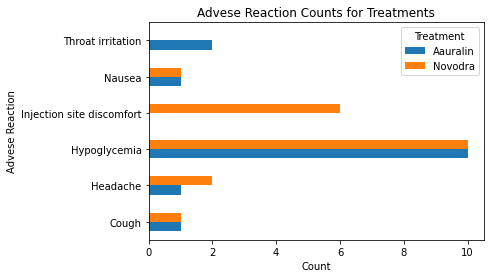

In [4]:
pd.crosstab(treatments.adverse_reaction.str.capitalize(), treatments.treatment).plot.barh()
plt.title('Advese Reaction Counts for Treatments')
plt.xlabel('Count')
plt.ylabel('Advese Reaction')
plt.legend(title='Treatment', labels=["Aauralin", "Novodra"]);

- Hypoglycemia, which is low blood sugar caused by an insulin overdose, is the most adverse reaction.
- Throat irritation is a side effect of Auralin, which can be expected because this bill is taken orally and passes by the throat before it gets to the stomach.


### Pre-trial/Post-trial Mean Insulin Dose Change (IU)
Q: Is Auralin requires a higher dosage to be effective?     
Analysis: Compare mean dose_change

In [5]:
treatments['dose_change'] = treatments.dose_end - treatments.dose_start

In [6]:
treatments.groupby('treatment').dose_change.mean()

treatment
auralin    8.325714
novodra   -0.385057
Name: dose_change, dtype: float64

Comparing dose change means, the patients that were treated with Auralin required on average 8 more units of insulin to establish a safe steady blood sugar level. For Novodra, patients on avertage required about 0.4 units less of insulin.     
The fact that Auralin required more units is kind of expected becuase we knew that oral insulin had a tougher time in getting to the bloodstream through the stomach lining. So the results are good for Auralin or at least they are not bad.

### HbA1c Change
Q: Is Auralin effective?   
Analysis: test the difference between the mean HbA1c changes for Novodra and Auralin with CI 95% (if Auralin causes a reduction in HbA1c that is similar to Novodra)        

**Domain expert**: (non-inferiority metric) CI difference upper limit < 0.4      
For Auralin to be deemed effective, it must be "noninferior" to Novodra, the current standard for insulin. This "noninferiority" is statistically defined as the upper bound of the 95% confidence interval being less than 0.4 for the difference between the mean HbA1c changes for Novodra and Auralin (i.e., Novodra minus Auralin).

$$H_0: \mu_{Novodra} - \mu_{Auralin} = 0$$
$$H_1: \mu_{Novodra} - \mu_{Auralin} \neq 0$$

In [7]:
treatments.groupby('treatment').mean().hba1c_change

treatment
auralin    0.387657
novodra    0.404713
Name: hba1c_change, dtype: float64

0.4 for Novodra compared to 0.39 for Auralin
 

In [8]:
treatments.groupby('treatment').size()

treatment
auralin    175
novodra    174
dtype: int64

In [9]:
treatments[treatments.treatment == 'auralin'].hba1c_change.mean()
treatments[treatments.treatment == 'novodra'].hba1c_change.mean()

0.40471264367816095

#### Confidence Interval and Hypothesis Testing
- Bootstraping and Sampling
- Traditional Statistical Tests

##### Method 1 

In [10]:
diffs = []

for _ in range(10000):
    bootsample = treatments.sample(treatments.shape[0], replace=True)
    aura_mean = bootsample[bootsample.treatment == 'auralin'].hba1c_change.mean()
    novo_mean = bootsample[bootsample.treatment == 'novodra'].hba1c_change.mean()
    diffs.append(novo_mean - aura_mean)
    


In [11]:
np.percentile(diffs, 2.5), np.percentile(diffs, 97.5)

(0.00456158741120791, 0.029233509589156208)

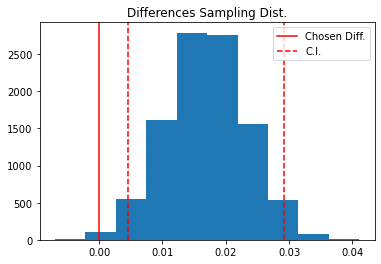

In [12]:
# difference between the means
hypothesis_value = 0

plt.hist(diffs)
plt.axvline(x=hypothesis_value, color='r', label='Chosen Diff.')
plt.axvline(x=np.percentile(diffs, 2.5), color='r', linestyle='--', label='C.I.')
plt.axvline(x=np.percentile(diffs, 97.5), color='r', linestyle='--')

plt.title('Differences Sampling Dist.')
plt.legend();

Regect the null hypothesis becuase the difference is out the confidence interval

##### Method 2 

In [13]:
observed_diff = treatments[treatments.treatment == 'novodra'].hba1c_change.mean() - \
                        treatments[treatments.treatment == 'auralin'].hba1c_change.mean()
diffs = np.array(diffs)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

# p-value
print("p-value is ", (null_vals > observed_diff).mean()) 
if (null_vals > observed_diff).mean() > 0.05:
    print("Failed to reject H0")
else:
    print("Reject H0")

p-value is  0.0024
Reject H0


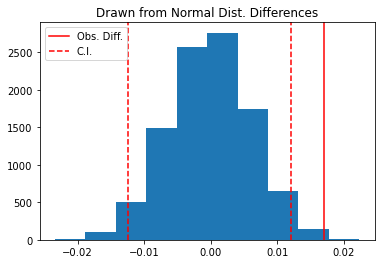

In [14]:
plt.hist(null_vals)
plt.axvline(x=observed_diff, color='r', label='Obs. Diff.')
plt.axvline(x=np.percentile(null_vals, 2.5), color='r', linestyle='--', label='C.I.')
plt.axvline(x=np.percentile(null_vals, 97.5), color='r', linestyle='--')

plt.title('Drawn from Normal Dist. Differences')
plt.legend();

##### Method 3 

In [15]:
import statsmodels.stats.api as sm

x1 = treatments[treatments.treatment == 'novodra'].hba1c_change
x2 = treatments[treatments.treatment == 'auralin'].hba1c_change

cm = sm.CompareMeans(sm.DescrStatsW(x1), sm.DescrStatsW(x2))
cm.tconfint_diff(usevar='unequal')

(0.004677519696701214, 0.02943348194533496)

In [16]:
cm.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.0171,0.006,2.710,0.007,0.005,0.029


After statistical analysis, we reject *H0: there is a difference* (the HbA1c_change difference between novodra and Auralin is zero), so (Auralin) oral insulin is similarly effective to (Novodra) injectable one and it does not break the upper limit. According to confidence interval of difference (0.0047, 0.0294), the upper limit (0.03) is less than 0.4. This means that Auralin passed Phase II clinical trials.